## The Goal...
is to take a look at my previous sentiment classifier in more detail and try to improve it by generating new or removing features and tuning parameters. 

### 1 - Load the Data
Below are the steps I used to build a model for sentiment analysis on yelp reviews.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import BernoulliNB
import string
from sklearn.model_selection import cross_val_score
import collections
from sklearn.metrics import confusion_matrix


C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
yelp = pd.read_csv('sentiment labelled sentences/yelp_labelled.txt', delimiter= '\t', header = None)
yelp.columns = ['sentence', 'positive']

In [3]:
keywords = ['not', 'terrible', 'bad', 'didn\'t', 'hated', 'nasty', 'slow', 'disgusting', 'worst', 'never', 'wasted', 'else',
           'hair', 'dry', 'dirty', 'expensive', 'wasted', 'overpriced']

In [4]:
for key in keywords:
    yelp[str(key)] = yelp.sentence.str.contains(key, case = False)

In [5]:
yelp['allcaps'] = yelp.sentence.str.isupper()

In [6]:
X = yelp[keywords + ['allcaps']]
Y = yelp['positive']

In [7]:
bern = BernoulliNB()
bern.fit(X, Y)
y_pred = bern.predict(X)
print('Accuracy: {}'.format((Y == y_pred).sum()/yelp.shape[0]))

Accuracy: 0.675


In [8]:
cm = confusion_matrix(Y, y_pred)
cm

array([[208, 292],
       [ 33, 467]], dtype=int64)

In [118]:
print('Sensitivity is {}'.format(cm[1][1]/sum(cm[1])))
print('Specificity is {}'.format(cm[0][0]/sum(cm[0])))

Sensitivity is 0.934
Specificity is 0.416


Just a reminder that the most basic model has an accuracy of 67.5% with a sensitivity and specificity of 93.4% and 41.6% respectively and a cross validation score of 66.9%.

In [104]:
cv_score = cross_val_score(bern, X, Y, cv=10)
print('Cross validation accuracy: {}'.format(cv_score.mean()))

Cross validation accuracy: 0.669


### 2 - First Iteration
For the first iteration, I wanted to see if I could improve on my previous model without turning to Google for more 'traditional' methods.  Other features to add are be number of words and punctuations.  In addition, I also noticed was that the 'allcaps' feature made the basic model worse, so I've removed it.

In [10]:
yelp1 = pd.read_csv('sentiment labelled sentences/yelp_labelled.txt', delimiter= '\t', header = None)
yelp1.columns = ['sentence', 'positive']

In [11]:
keywords = ['not', 'terrible', 'bad', 'didn\'t', 'hated', 'nasty', 'slow', 'disgusting', 'worst', 'never', 'wasted', 'else',
           'hair', 'dry', 'dirty', 'expensive', 'wasted', 'overpriced']

In [12]:
for key in keywords:
    yelp1[str(key)] = yelp1.sentence.str.contains(key, case = False)

In [13]:
yelp1['length'] = yelp1['sentence'].apply(lambda s: len(s.split(' ')))

In [14]:
yelp1['punct']= yelp1['sentence'].apply(lambda sen: len([c for c in sen if c in string.punctuation ]))

In [15]:
X1 = yelp1.drop(['positive', 'sentence'], axis = 1)
Y1 = yelp1['positive']

The correlation matrix shows there is minimal correlation between each feature. Great!

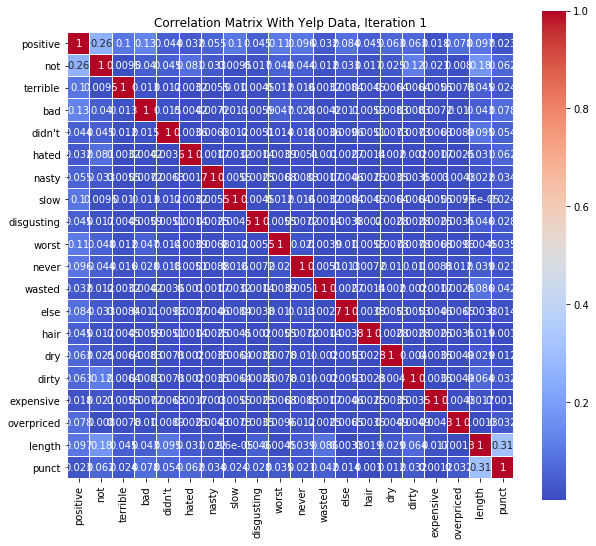

In [16]:
plt.figure(figsize=(10,9))
sns.heatmap(np.absolute(yelp1.corr()), annot = True, square = True, linewidths=0.01, cmap = 'coolwarm')
plt.title('Correlation Matrix With Yelp Data, Iteration 1')

Training the whole dataset gives an accuracy of 67.6%, slightly worse than the original model. This comes from the specificity being lower.  In addition, I performed cross validation to check for overfitting, and the accuracy came out to be slightly lower, at 66.9%.  There is some overfitting, but not too badly.  

In [17]:
bern1 = BernoulliNB()
bern1.fit(X1, Y1)
y_pred1 = bern1.predict(X1)
print('Accuracy: {}'.format((Y1 == y_pred1).sum()/yelp1.shape[0]))

Accuracy: 0.674


In [18]:
cm1 = confusion_matrix(Y1, y_pred1)

In [119]:
print('Sensitivity is {}'.format(cm1[1][1]/sum(cm1[1])))
print('Specificity is {}'.format(cm1[0][0]/sum(cm1[0])))

Sensitivity is 0.934
Specificity is 0.414


In [20]:
cv_score1 = cross_val_score(bern1, X1, Y1, cv=10)
print('Cross validation accuracy: {}'.format(cv_score1.mean()))

Cross validation accuracy: 0.6679999999999999


### 3 - Second Iteration
For the second iteration, I wanted to try a more methodical approach.  The keywords I used above were just words I remembered from reading past yelp reviews and a quick scan of the dataset.  A better approach would be find the most common words from the negative reviews sans common words such as 'the', 'and', 'or', etc.  These common words are a modified list from nltk's stopwords.  In order to apply this method though, first I had to manipulate the sentences so that they are lowercase, stripped of white space, and have punctuation removed.

In [21]:
yelp2 = pd.read_csv('sentiment labelled sentences/yelp_labelled.txt', delimiter= '\t', header = None)
yelp2.columns = ['sentence', 'positive']

In [22]:
yelp2['sentence'] = yelp2['sentence'].apply(lambda s: s.lower().translate(str.maketrans('', '', string.punctuation)))

In [23]:
stop_words = ['hers', 'between', 'about', 'during', 'out', 'very', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its',
             'yours', 'such', 'into', 'of', 'itself', 'other', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 
             'the', 'themselves', 'until', 'below', 'are', 'we' 'these' 'your', 'his', 'through', 'don', 'nor', 'me', 'were',
             'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours',
             'had', 'she', 'all', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'benn', 'have', 'in', 'will', 'on',
             'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'so', 'can', 'did', 'now', 'he', 'you', 
             'herself', 'has', 'just', 'where', 'too', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being',
             'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'than', 'here', 'ive', 
              'im']



In [24]:
neg_count = collections.Counter()
neg_word_list = []
for sentence in yelp2[yelp2['positive']==0]['sentence']:
    splt = sentence.split(' ')
    for i in range(len(splt)):
        if splt[i].lower() not in stop_words:
            neg_word_list.append((splt[i]).lower())
neg_count.update(neg_word_list)

In [25]:
common_neg_words = [word[0] for word in neg_count.most_common()[:15]] + [word[0] for word in neg_count.most_common()[16:41]]

For now, I will include words that have more than 10 counts, meaning there are 40 keywords in total.  

In [26]:
for key in common_neg_words:
    yelp2[str(key)] = yelp2.sentence.str.contains(key, case = False)

In [27]:
X2 = yelp2.drop(['positive', 'sentence'], axis = 1)
Y2 = yelp2['positive']

With 40 variables, the heatmap is considerably larger than the first iteration.  Also, there are some words that are correlated with each other, namely no:not, good:go, and ever:never.

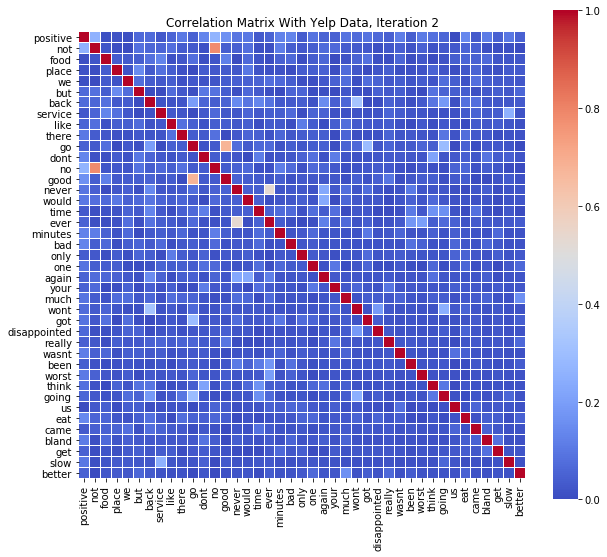

In [28]:
plt.figure(figsize=(10,9))
sns.heatmap(np.absolute(yelp2.corr()), annot = False, square = True, linewidths=0.01, cmap = 'coolwarm')
plt.title('Correlation Matrix With Yelp Data, Iteration 2')

These new keywords raised the accuracy to 71.4%, with sensitivity and specificity of 82.4% and 60.4% respectively.  From the original model, the sensitivity decreased but the specificity increased.

Cross validation shows that there is more than 1% decrease, so the overfitting is more prominent in this iteration.

In [32]:
bern2 = BernoulliNB()
bern2.fit(X2, Y2)
y_pred2 = bern2.predict(X2)
print('Accuracy: {}'.format((Y2 == y_pred2).sum()/yelp2.shape[0]))

Accuracy: 0.714


In [120]:
cm2 = confusion_matrix(Y2, y_pred2)
print('Sensitivity is {}'.format(cm2[1][1]/sum(cm2[1])))
print('Specificity is {}'.format(cm2[0][0]/sum(cm2[0])))

Sensitivity is 0.824
Specificity is 0.604


In [34]:
cv_score2 = cross_val_score(bern2, X2, Y2, cv=10)
print('Cross validation accuracy: {}'.format(cv_score2.mean()))

Cross validation accuracy: 0.7010000000000001


### 4 - Third Iteration
If I made a list of negative keywords, then surely there is a different list for positive keywords.  Much of the preprocessing work is the same.  The main difference is that I'm finding the most common words from positively labeled sentences.  

In [35]:
yelp3 = pd.read_csv('sentiment labelled sentences/yelp_labelled.txt', delimiter= '\t', header = None)
yelp3.columns = ['sentence', 'positive']

In [36]:
yelp3['sentence'] = yelp3['sentence'].apply(lambda s: s.lower().translate(str.maketrans('', '', string.punctuation)))

In [37]:
pos_count = collections.Counter()
pos_word_list = []
for sentence in yelp3[yelp3['positive']==1]['sentence']:
    splt = sentence.split(' ')
    for i in range(len(splt)):
        if splt[i].lower() not in stop_words:
            pos_word_list.append((splt[i]).lower())
pos_count.update(pos_word_list)

In [50]:
common_pos_words = [word[0] for word in pos_count.most_common()[:6]] + [word[0] for word in pos_count.most_common()[7:43]]

In [51]:
for key in common_pos_words:
    yelp3[str(key)] = yelp3.sentence.str.contains(key, case = False)

In [53]:
X3 = yelp3.drop(['positive', 'sentence'], axis = 1)
Y3 = yelp3['positive']

Surprisingly, there is a similarly high correlation between go:good.  The other pair that is correlated is love:loved.

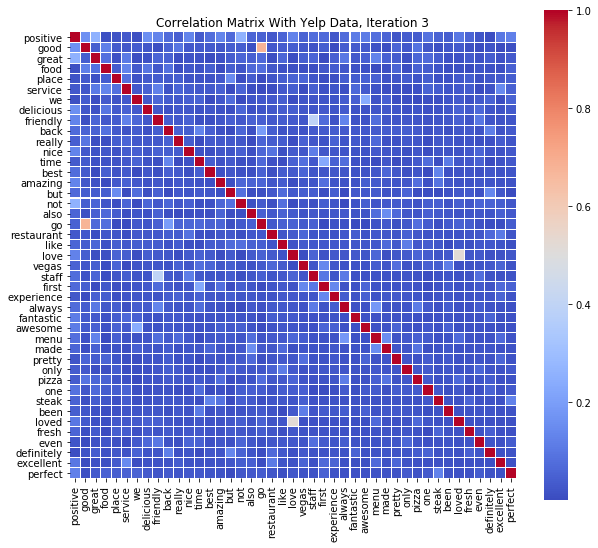

In [54]:
plt.figure(figsize=(10,9))
sns.heatmap(np.absolute(yelp3.corr()), annot = False, square = True, linewidths=0.01, cmap = 'coolwarm')
plt.title('Correlation Matrix With Yelp Data, Iteration 3')

I'd have expected these positive keywords to have similar results as the negative keywords, but instead they have an accuracy of 77.7%, ~6% better than negative keywords.  Here, sensitivity is 64.8% and specificity is 90.6%.  As expected, cross validation has a slightly lower score, about 1% lower.

In [55]:
bern3 = BernoulliNB()
bern3.fit(X3, Y3)
y_pred3 = bern3.predict(X3)
print('Accuracy: {}'.format((Y3 == y_pred3).sum()/yelp3.shape[0]))

Accuracy: 0.777


In [56]:
cm3 = confusion_matrix(Y3, y_pred3)
print('Sensitivity is {}'.format(cm3[1][1]/sum(cm3[1])))
print('Specificity is {}'.format(cm3[0][0]/sum(cm3[0])))

Sensitivity is 0.648
Specificity is 0.906


In [57]:
cv_score3 = cross_val_score(bern3, X3, Y3, cv=10)
print('Cross validation accuracy: {}'.format(cv_score3.mean()))

Cross validation accuracy: 0.764


### 5 - Fourth Iteration
What happens to the accuracy if we combine the positive and negative keywords?

In [58]:
yelp4 = pd.read_csv('sentiment labelled sentences/yelp_labelled.txt', delimiter= '\t', header = None)
yelp4.columns = ['sentence', 'positive']
yelp4['sentence'] = yelp4['sentence'].apply(lambda s: s.lower().translate(str.maketrans('', '', string.punctuation)))

In [60]:
for key in common_pos_words:
    yelp4[str(key)] = yelp4.sentence.str.contains(key, case = False)
for key in common_neg_words:
    yelp4[str(key)] = yelp4.sentence.str.contains(key, case = False)

In [68]:
X4 = yelp4.drop(['positive', 'sentence'], axis = 1)
Y4 = yelp4['positive']

In [70]:
bern4 = BernoulliNB()
bern4.fit(X4, Y4)
y_pred4 = bern4.predict(X4)
print('Accuracy: {}'.format((Y4 == y_pred4).sum()/yelp4.shape[0]))

Accuracy: 0.753


In [121]:
cm4 = confusion_matrix(Y4, y_pred4)
print('Sensitivity is {}'.format(cm4[1][1]/sum(cm4[1])))
print('Specificity is {}'.format(cm4[0][0]/sum(cm4[0])))

Sensitivity is 0.81
Specificity is 0.696


In [73]:
cv_score4 = cross_val_score(bern4, X4, Y4, cv=10)
print('Cross validation accuracy: {}'.format(cv_score4.mean()))

Cross validation accuracy: 0.737


Seems like combining the two keywords wasn't as good as just the positive keywords, with about a 2% drop in both accuracy and cross validation score compared to the positive keyword model.

### 6 - Fifth Iteration
Some of the words in the positive and negative keyword lists are the same.  If I took away the common words, would that improve the accuracy?  In this case, I will look at unique positive keywords.  Originally, the positive keyword list had 42 words.  With only unique positive keywords, the number drops to 27.

In [90]:
yelp5 = pd.read_csv('sentiment labelled sentences/yelp_labelled.txt', delimiter= '\t', header = None)
yelp5.columns = ['sentence', 'positive']
yelp5['sentence'] = yelp5['sentence'].apply(lambda s: s.lower().translate(str.maketrans('', '', string.punctuation)))

In [91]:
unique_good  = [word for word in common_pos_words if word not in common_neg_words]
len(unique_good)

27

In [92]:
for key in unique_good:
    yelp5[str(key)] = yelp5.sentence.str.contains(key, case = False)

In [93]:
X5 = yelp5.drop(['positive', 'sentence'], axis = 1)
Y5 = yelp5['positive']

The accuracy dropped to 72.4%, with sensitivity and specificity of 55% and 89.8%.  Cross validation score is ~1.5% lower than accuracy score.

In [94]:
bern5 = BernoulliNB()
bern5.fit(X5, Y5)
y_pred5 = bern5.predict(X5)
print('Accuracy: {}'.format((Y5 == y_pred5).sum()/yelp5.shape[0]))

Accuracy: 0.724


In [122]:
cm5 = confusion_matrix(Y5, y_pred5)
print('Sensitivity is {}'.format(cm5[1][1]/sum(cm5[1])))
print('Specificity is {}'.format(cm5[0][0]/sum(cm5[0])))

Sensitivity is 0.55
Specificity is 0.898


In [96]:
cv_score5 = cross_val_score(bern5, X5, Y5, cv=10)
print('Cross validation accuracy: {}'.format(cv_score5.mean()))

Cross validation accuracy: 0.71


### 7 - Questions
There are three questions to address:
1.  Do any of your classifiers seem to overfit?
2.  Which seem to perform the best? Why?
3.  Which features seemed to be most impactful to performance?

First though, I need a table that summarizes the results.  

| Iteration | Accuracy   | Sensitivity | Specificity   | Mean CV Score   |
|------|------|
|   Original  | 67.5|   93.4  | 41.6|   66.9  |
|   1 - Number of words and punctuation  | 67.4|   93.4  | 41.4|   66.8  |
|   2 - Common Negative Keywords  | 71.4|   82.4  | 60.4|   70.1  |
|   3 - Common Positive Keywords  | 77.7|   64.8  | 90.6|   76.4  |
|   4 - Combined Positive and Negative Keywords  | 75.3|   81  | 69.6|   73.7  |
|   5 - Unique Positive Keywords  | 72.4 |   55  | 89.8|   71  |

#### 7.1 Did Any Classifiers Overfit?
The way to tell if a classifier is overfitting is by separating the data into two, a training and a test set.  Using cross validation (CV) is one way to separate the data, especially if the dataset is small like this yelp data is.  If the mean CV score is lower than the accuracy score, which trained on the whole model, then we know the classifier overfit.  

From the table above, accuracy score was always higher CV score, but never more than 2%, indicating that **yes, there was overfitting.*

#### 7.2 - Which seemed to perform the best?  Why?
The one that performed the best was the model with common positive keywords.  Of all the models, it had the highest specificity and relatively good sensitivity.  

I had expected the model that combined positive and negative keywords to be the best, but it performed second best.  The most likely reason is that I didn't remove any of the correlated keywords, so the classifier put extra weight on those correlated pairs, some of which could have predicted incorrectly.  

#### 7.3 - Which Features Seemed to have the Biggest Impact?
Below, I've printed out the 10 most important features from the 3rd model.  The words are associated with high praise, such as 'perfect' or 'fantastic'.  Indeed, these words are what I expect to be good predictors for sentiment analysis. 

In [132]:
imp_feat_idx = bern3.feature_log_prob_[0, :].argsort()[:10]

In [133]:
for i in imp_feat_idx:
    print(common_pos_words[i])

perfect
fantastic
awesome
delicious
excellent
loved
great
amazing
friendly
menu
